 ## HW2 - Satellite image classification 

Johnathan Clementi    
MUSA - 650 Remote Sensing    
3/16/2022   


Include your code in the relevant cells below. Subparts labeled as questions (Q1.1, Q1.2, etc.) should have their answers filled in place or plots placed prominently, as appropriate.

Please make sure to remove irrelevant code or outputs, and to include descriptive comments with all of your code.

In [24]:
!pip install tifffile

In [2]:
# import json
import os
import pandas as pd
import numpy as np
from math import *
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

#### Import data
This dataset comes from https://www.kaggle.com/rhammell/planesnet

In [3]:
# If using Google Colab, run this code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
directory = '/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW2'
data_directory = '{}/Data'.format(directory)

In [28]:
print(os.listdir(data_directory))

['planesnet.json', 'planesnet']


In [5]:
df = pd.read_json('{}/planesnet.json'.format(data_directory))

In [15]:
#############################################################
#### Remove this code when running for final submission #####
#### down sample so models run quickly ######################
df = df.groupby('labels').sample(frac = 0.3, random_state = 123)

In [30]:
# If running code locally, run this code
#path = os.getcwd()
# print(os.listdir("{}/data".format(path)))
#df = pd.read_json('{}/data/planesnet.json'.format(path))

### S1:

- Load the Planes in Satellite Imagery dataset: https://www.kaggle.com/rhammell/planesnet.


Q1.1: Visualize a few of the images for different labels.

Q1.2: What is the total number of images in this dataset:   32,000

Q1.3: What is the number of labels in this dataset:

<table>
  <tr><th>Label<th>Count
  <tr><td> 0 <td> 24000
  <tr><td> 1 <td> 8000
</table>

Q1.4: What is the dimensionality of each image in this dataset:   
Each image is 20 x 20 x 3

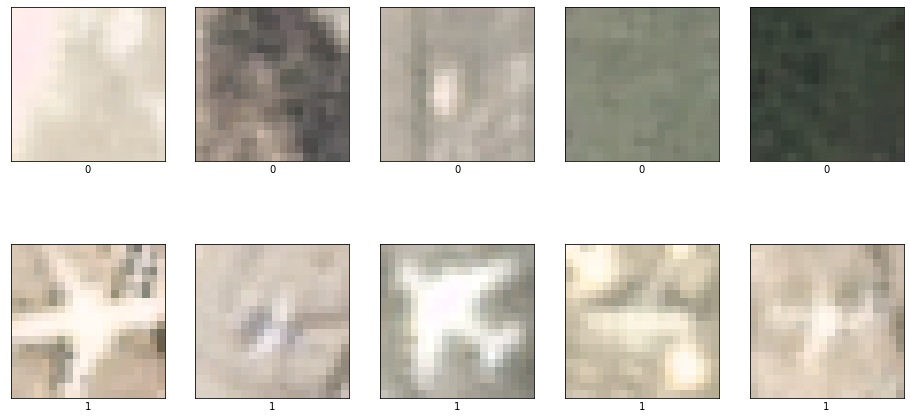

In [17]:
# Q 1.1: Visualize a few images for different labels

viz = df.groupby('labels').sample(n = 5, random_state = 123)

plt.figure(figsize=(16,8))

for i in range(10):
  # Choose random img and its label
  # randIdx = random.randrange(0, len(df['data']))
  img = np.array(viz['data'].iloc[i])
  img = img.reshape((3, 400)).T.reshape(20,20,3) # T is for transpose
  label = viz['labels'].iloc[i]

  # Display img
  plt.subplot(2,5,i+1)
  plt.xticks([]) # Remove tick marks on x axis
  plt.yticks([]) # Remove tick marks on y axis
  plt.imshow(img)
  plt.xlabel(label)

plt.show()

In [16]:
# Q1.2
count = df['labels'].value_counts()
print(count)

# Q1.4
# np.array(viz['data'].iloc[i]).shape

0    7200
1    2400
Name: labels, dtype: int64


### S2:

- Create data matrices X and y as follows:
  - Extract the color channels from each image and flatten them to a feature matrix X (*Hint: use the included JSON file to do this easily*).
  - Create the labels y (with binary labels 0 and 1) for each image.
- Using X and y, create a split dataset with 70% training and 30% testing data with similar distributions for the two classes.

Q2.1: What is the size of X (before splitting):   ___

Q2.2: What is the size of y (before splitting):   ___

In [19]:
X = np.vstack(df.iloc[:,0].values)
y = np.ravel(df.iloc[:,1].values)

In [20]:
print(X)
print(y)

[[187 176 173 ... 133 147 147]
 [142 145 146 ...  93 102 105]
 [226 229 231 ... 165 166 166]
 ...
 [195 194 201 ... 193 187 192]
 [199 194 187 ... 170 178 188]
 [215 208 208 ... 162 165 166]]
[0 0 0 ... 1 1 1]


In [21]:
print(X.shape)
print(y.shape)

(9600, 1200)
(9600,)


In [22]:
# Scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [23]:
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, random_state = 123, stratify = y)

In [24]:
print(X1.shape)
print(X2.shape)
print(y1.shape)
print(y2.shape)

(6720, 1200)
(2880, 1200)
(6720,)
(2880,)


### S3:

- Train a SVM classifier using the Sigmoid kernel (with default values for other parameters) on the training data and use it to predict labels of the testing data.

Q3.1: What is the training accuracy: ___

Q3.2: What is the testing accuracy: ___

Q3.3: Show the confusion matrix for the classification of testing samples.

Q3.4: What is the AUC (area under the curve) for the classification of testing samples : ___


In [25]:
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', random_state = 123)

print('Train size: ' + str(y1.shape[0]))

### Training the model
print('Training the model ...')
svc.fit(X1, y1)

print('Applying the model ...')
yPred = svc.predict(X2)

print('Accuracy: ' + str(100 * np.sum(yPred==y2) / y2.shape[0]))

Train size: 6720
Training the model ...
Applying the model ...
Accuracy: 73.81944444444444


In [26]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc

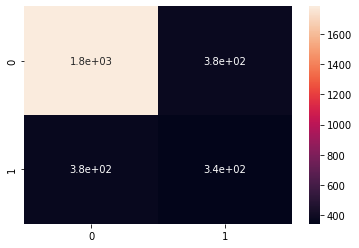

In [27]:
sns.heatmap(confusion_matrix(y2, yPred), annot=True)
plt.show()

In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y2, yPred, pos_label=2)
metrics.auc(fpr, tpr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan

### S4:
- Train a new SVM classifier using the RBF kernel (leaving other parameters as their default values), and use it to predict labels of the testing data.

Q4.1: What is the training accuracy: ___

Q4.2: What is the testing accuracy: ___

Q3.3: Show the confusion matrix: ___

Q3.4: What is the AUC (area under the curve) for the classification: ____ 

Q4.5: Using the metrics of accuracy and AUC, which of your models is better? Is there anything else to consider?

In [34]:
svc_rbf = SVC(kernel='rbf')

print('Train size: ' + str(y1.shape[0]))

### Training the model
print('Training the model ...')
svc_rbf.fit(X1, y1)
y_score = svc_rbf.fit(X1, y1).decision_function(X2)


print('Applying the model ...')
yPred = svc_rbf.predict(X2)

print('Testing Accuracy: ' + str(100 * np.sum(yPred==y2) / y2.shape[0]))

Train size: 6720
Training the model ...
Applying the model ...
Testing Accuracy: 93.64583333333333


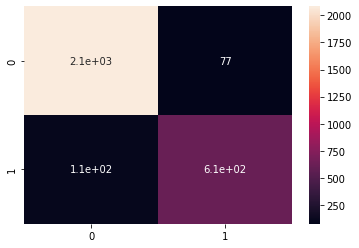

In [35]:
sns.heatmap(confusion_matrix(y2, yPred), annot=True)
plt.show()

### S5:
- You will now try to find the best value for the regularization parameter $C$ from among the values [0.1, 1, 10].
- Train a SVM classifier with Sigmoid kernel with different values for $C$ using leave-10%-out cross-validation within your training data.
- Train a SVM classifier with RBF kernel with different values for $C$ using leave-10%-out cross-validation within your training data.
- Select the best model parameters (from the 6 models: 2 SVM kernels x 3 parameters) based on highest cross-validated accuracy. Train the selected model on the complete training set and apply on the testing set.

Q5.1: What is the best choice of $C$ for the linear kernel: ___

Q5.2: What is the best choice of $C$ for the RBF kernel: ___

Q5.3: What is the accuracy of best model on testing data: ___


### S6:

Unsupervised learning: Clustering

- Apply k-Means clustering with k=2 on the complete set using vectorized imaging features

Q6.1: What is the distribution of plane vs non-plane images into the two classes? Show it with a 2x2 matrix: ___

Q6.2: Does the clustering (without using actual labels in learning) work for detecting the two target classes? Why or why not?


### S7:

Visualization

- Show the average of all airplane images

- Show the average of all images in your first cluster in S6

- Show the average of all images in your second cluster in S6


Q7.1: Based on what you see in these average images, what would you suggest to improve your classifier for differentiating these two classes?


### S8 (Bonus):

Extract only 5 features from each image [1]. Train a linear classifier with default parameters on the training data using only these 5 features and apply it on the test data.

[1] Feature extraction should be done without using the class labels

Q8.1: Describe how you extracted your 5 features. How did you choose them?

Q8.2: What is the accuracy of your classifier on the test data: ___

